In [1]:
# IMPORTS
import sys
import gc
import os
from tqdm import tqdm

sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchvision.models import efficientnet_b0

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import MinMaxScaler
import albumentations as albu
import pywt, librosa

import logging

logger = logging.getLogger("pytorch_lightning")
logger.setLevel(logging.INFO)

handler = logging.StreamHandler()
handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

In [2]:
# GLOBAL VARS

VERSION = 5
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/'
DEFAULT_SPECS_PATH = f'{PATH}train_spectrograms/'
KAGGLE_EEG_SPECS_PATH = f'/kaggle/input/brain-eeg-spectrograms/EEG_Spectrograms/'
# IF THIS EQUALS NONE, THEN WE data NEW MODELS
# IF THIS EQUALS DISK PATH, THEN WE LOAD PREVIOUSLY dataED MODELS
LOAD_MODELS_FROM = '/kaggle/input/hms-efficientnetb0-pt-ckpts'

WEIGHTS_FILE = '/kaggle/input/hms-efficientnetb0-pt-ckpts/efficientnet_b0_rwightman-7f5810bc.pth' if 1 else None

USE_KAGGLE_SPECTROGRAMS = True
USE_EEG_SPECTROGRAMS = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# READ DATA
df = pd.read_csv(f'{PATH}train.csv')
TARGETS = df.columns[-6:]
print('data shape:', df.shape )
print('Targets', list(TARGETS))
df.head(10)

data shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
5,1628180742,5,26.0,353733,5,26.0,2413091605,42516,Seizure,3,0,0,0,0,0
6,1628180742,6,30.0,353733,6,30.0,364593930,42516,Seizure,3,0,0,0,0,0
7,1628180742,7,36.0,353733,7,36.0,3811483573,42516,Seizure,3,0,0,0,0,0
8,1628180742,8,40.0,353733,8,40.0,3388718494,42516,Seizure,3,0,0,0,0,0
9,2277392603,0,0.0,924234,0,0.0,1978807404,30539,GPD,0,0,5,0,1,5


In [4]:
# DATA PREPROCESS

def get_nonoverlapping_data(df):
    data = df.groupby('eeg_id')[['spectrogram_id', 'spectrogram_label_offset_seconds']].agg(
        {'spectrogram_id': 'first', 'spectrogram_label_offset_seconds': 'min'}
        )
    data.columns = ['spec_id', 'min']

    tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
        {'spectrogram_label_offset_seconds' :'max'}
        )
    data['max'] = tmp

    tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
    data['patient_id'] = tmp

    tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
    for t in TARGETS:
        data[t] = tmp[t].values
        
    y_data = data[TARGETS].values
    y_data = y_data / y_data.sum(axis=1, keepdims=True)
    data[TARGETS] = y_data

    tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
    data['target'] = tmp

    data = data.reset_index()
    print('data non-overlapp eeg_id shape:', data.shape )
    data.head()
    
    return data

train = get_nonoverlapping_data(df)

data non-overlapp eeg_id shape: (17089, 12)


In [5]:
# READ SPECS

READ_SPEC_FILES = True

# READ ALL SPECTROGRAMS
files = os.listdir(DEFAULT_SPECS_PATH)

if READ_SPEC_FILES:    
    spectrograms = {}
    for i,f in tqdm(enumerate(files), total=len(files)):
        tmp = pd.read_parquet(f'{DEFAULT_SPECS_PATH}{f}')
        spec_id = int(f.split('.')[0])
        spectrograms[spec_id] = tmp.iloc[:,1:].values
else:
    print('not reading kaggle default specs')
    spectrograms = np.load('/kaggle/working/specs.npy',allow_pickle=True).item()

100%|██████████| 11138/11138 [07:35<00:00, 24.44it/s]


In [6]:
READ_EEG_SPEC_FILES = True

if READ_EEG_SPEC_FILES:
    all_eegs = {}
    for i,e in tqdm(enumerate(train.eeg_id.values), total=len(train)):
        x = np.load(f'/kaggle/input/brain-eeg-spectrograms/EEG_Spectrograms/{e}.npy')
        all_eegs[e] = x
else:
    print('not reading eeg specs')
    all_eegs = np.load('/kaggle/working/eeg_specs.npy',allow_pickle=True).item()

100%|██████████| 17089/17089 [02:52<00:00, 98.84it/s] 


In [7]:
# np.save('/kaggle/working/specs.npy', spectrograms, allow_pickle=True)
# np.save('/kaggle/working/eeg_specs.npy', all_eegs, allow_pickle=True)

In [8]:
def draw_spec(spec):
    plt.figure(figsize=(11, 7))
    spec = spec[:].T
    
    spec = np.clip(spec, np.exp(-4), np.exp(8))
    spec = np.log(spec)
    
    spec = (spec - np.nanmean(spec.flatten()) / (np.nanstd(spec.flatten() + 1e-6)))
    spec = np.nan_to_num(spec, nan=0.0)
    
    mx = spec.max()
    mn = spec.min()
    spec = ((spec - mn) / (mx - mn))
    plt.imshow(spec)

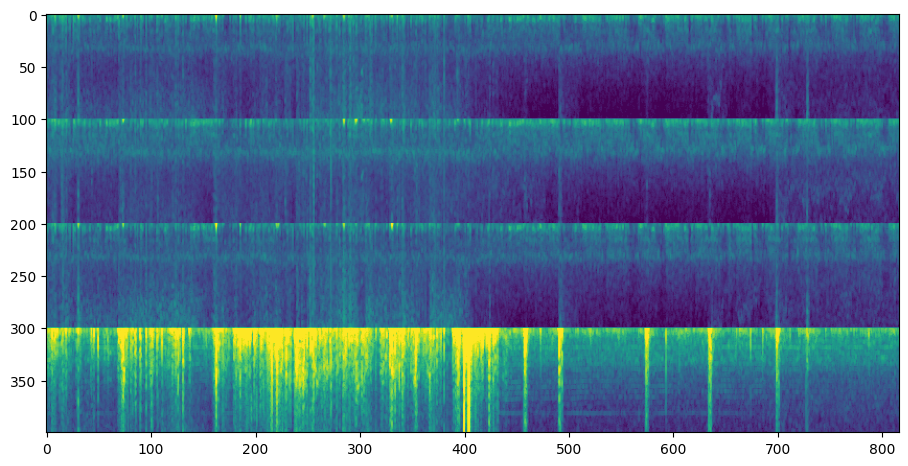

In [9]:
draw_spec(pd.read_parquet(f'{DEFAULT_SPECS_PATH}/14960202.parquet').iloc[:, 1:].values)

In [10]:
# DATASET

TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
TARS2 = {x: y for y, x in TARS.items()}

class EEGDataset(Dataset):
    
    def __init__(
                self, data, augment=False, mode='train',
                specs=None, specs_path = None, 
                eeg_specs=None, eeg_path=None
                 ): 
        self.data = data
        self.augment = augment
        self.mode = mode
        
        self.specs = specs
        self.specs_path = specs_path
        
        self.eeg_specs = eeg_specs
        self.eeg_path = eeg_path
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.__getitems__([index])
    
    def __getitems__(self, indices):
        X, y = self._generate_data(indices)
        
        if self.augment:
            X = self._augment(X) 
            
        if self.mode == 'train':
            return list(zip(X, y))
        else:
            return X
    
    
    def _generate_data(self, indexes):
        X = np.zeros((len(indexes), 128, 256, 8),dtype='float32')
        y = np.zeros((len(indexes), 6),dtype='float32')
        img = np.ones((128, 256),dtype='float32')

        
        for i, index in enumerate(indexes):
            row = self.data.iloc[index]
            
            if self.specs_path is not None:
                cur_spec = pd.read_parquet(f'{self.specs_path}{row.spec_id}.parquet').iloc[:, 1:].values
            else:
                cur_spec = self.specs[row.spec_id]
            
            if self.mode == 'test': 
                r = 0
            else: 
                r = int((row['min'] + row['max'])//4)

            for k in range(4):
                # EXTRACT 300 ROWS OF SPECTROGRAM
                img = cur_spec[r:r+300, k*100:(k+1)*100].T
                
                # LOG TRANSFORM SPECTROGRAM
                img = np.clip(img, np.exp(-4), np.exp(8))
                img = np.log(img)
                
                # STANDARDIZE PER IMAGE
                ep = 1e-6
                m = np.nanmean(img.flatten())
                s = np.nanstd(img.flatten())
                img = (img - m) / (s + ep)
                img = np.nan_to_num(img, nan=0.0)
                
                # CROP TO 256 TIME STEPS
                X[i, 14:-14, :, k] = img[:, 22:-22] / 2.0
        
            # EEG SPECTROGRAMS
            if self.eeg_path is not None:
                img = np.load(f'{self.eeg_path}{row.eeg_id}.npy')
            else:
                img = self.eeg_specs[row.eeg_id]
            X[i, :, :, 4:] = img
                
            if self.mode != 'test':
                y[i,] = row[TARGETS]
            
        return X, y
    
    def _random_transform(self, img):
        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),
            # albu.CoarseDropout(max_holes=8,max_height=32,max_width=32,fill_value=0,p=0.5),
        ])
        return composition(image=img)['image']
            
    def _augment(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i,] = self._random_transform(img_batch[i,])
        return img_batch

In [11]:
eeg_dataset = EEGDataset(train, augment=False, specs_path=DEFAULT_SPECS_PATH, eeg_path=KAGGLE_EEG_SPECS_PATH)
eeg_dataloader = DataLoader(eeg_dataset, 64, shuffle=False)

In [12]:
class EEGEffnetB0(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        self.base_model = efficientnet_b0()
        if WEIGHTS_FILE is not None:
            self.base_model.load_state_dict(torch.load(WEIGHTS_FILE))
            
        self.base_model.classifier[1] = nn.Linear(self.base_model.classifier[1].in_features, 6, dtype=torch.float32)
        # self.prob_out = nn.Softmax()
        
    def forward(self, x):
        x1 = [x[:, :, :, i:i+1] for i in range(4)]
        x1 = torch.concat(x1, dim=1)
        x2 = [x[:, :, :, i+4:i+5] for i in range(4)]
        x2 = torch.concat(x2, dim=1)
        
        if USE_KAGGLE_SPECTROGRAMS & USE_EEG_SPECTROGRAMS:
            x = torch.concat([x1, x2], dim=2)
        elif USE_EEG_SPECTROGRAMS:
            x = x2
        else:
            x = x1
            
        x = torch.concat([x, x, x], dim=3)
        x = x.permute(0, 3, 1, 2)
        out = self.base_model(x)
        
        return out
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.forward(x)
        out = F.log_softmax(out, dim=1)
        kl_loss = nn.KLDivLoss(reduction='batchmean')
        loss = kl_loss(out, y)
        return loss
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return F.softmax(self(batch), dim=1)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [13]:
del eeg_dataset, eeg_dataloader
gc.collect()

4003

In [14]:
all_oof = []
all_true = []

valid_loaders = []

gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):  
    print('#'*25)
    print(f'### Fold {i+1}')
    
    train_ds = EEGDataset(train.iloc[train_index], True, specs=spectrograms, eeg_specs=all_eegs)
    train_loader = DataLoader(train_ds, shuffle=True, batch_size=64, num_workers=3)
    valid_ds = EEGDataset(train.iloc[valid_index], mode='valid', specs=spectrograms, eeg_specs=all_eegs)
    valid_loader = DataLoader(valid_ds, shuffle=False, batch_size=64, num_workers=3)
    
    print(f'### Train size: {len(train_index)}, Valid size: {len(valid_index)}')
    print('#'*25)
    trainer = pl.Trainer(max_epochs=4, logger=True, devices=2, accelerator="gpu")
    model = EEGEffnetB0()
    if LOAD_MODELS_FROM is None:
        trainer.fit(model=model, train_dataloaders=train_loader)
        trainer.save_checkpoint(f'EffNet_v{VERSION}_f{i}.ckpt')

    valid_loaders.append(valid_loader)
    all_true.append(train.iloc[valid_index][TARGETS].values)
    
    del trainer, model
    gc.collect()

#########################
### Fold 1
### Train size: 13671, Valid size: 3418
#########################


2024-02-14 12:43:48,738 - pytorch_lightning.utilities.rank_zero - INFO - GPU available: True (cuda), used: True
2024-02-14 12:43:48,846 - pytorch_lightning.utilities.rank_zero - INFO - TPU available: False, using: 0 TPU cores
2024-02-14 12:43:48,847 - pytorch_lightning.utilities.rank_zero - INFO - IPU available: False, using: 0 IPUs
2024-02-14 12:43:48,848 - pytorch_lightning.utilities.rank_zero - INFO - HPU available: False, using: 0 HPUs
2024-02-14 12:43:49,602 - pytorch_lightning.utilities.rank_zero - INFO - GPU available: True (cuda), used: True
2024-02-14 12:43:49,603 - pytorch_lightning.utilities.rank_zero - INFO - TPU available: False, using: 0 TPU cores
2024-02-14 12:43:49,604 - pytorch_lightning.utilities.rank_zero - INFO - IPU available: False, using: 0 IPUs
2024-02-14 12:43:49,605 - pytorch_lightning.utilities.rank_zero - INFO - HPU available: False, using: 0 HPUs


#########################
### Fold 2
### Train size: 13671, Valid size: 3418
#########################


2024-02-14 12:43:50,023 - pytorch_lightning.utilities.rank_zero - INFO - GPU available: True (cuda), used: True
2024-02-14 12:43:50,024 - pytorch_lightning.utilities.rank_zero - INFO - TPU available: False, using: 0 TPU cores
2024-02-14 12:43:50,025 - pytorch_lightning.utilities.rank_zero - INFO - IPU available: False, using: 0 IPUs
2024-02-14 12:43:50,026 - pytorch_lightning.utilities.rank_zero - INFO - HPU available: False, using: 0 HPUs


#########################
### Fold 3
### Train size: 13671, Valid size: 3418
#########################


2024-02-14 12:43:50,452 - pytorch_lightning.utilities.rank_zero - INFO - GPU available: True (cuda), used: True
2024-02-14 12:43:50,453 - pytorch_lightning.utilities.rank_zero - INFO - TPU available: False, using: 0 TPU cores
2024-02-14 12:43:50,454 - pytorch_lightning.utilities.rank_zero - INFO - IPU available: False, using: 0 IPUs
2024-02-14 12:43:50,454 - pytorch_lightning.utilities.rank_zero - INFO - HPU available: False, using: 0 HPUs


#########################
### Fold 4
### Train size: 13671, Valid size: 3418
#########################


2024-02-14 12:43:50,858 - pytorch_lightning.utilities.rank_zero - INFO - GPU available: True (cuda), used: True
2024-02-14 12:43:50,859 - pytorch_lightning.utilities.rank_zero - INFO - TPU available: False, using: 0 TPU cores
2024-02-14 12:43:50,860 - pytorch_lightning.utilities.rank_zero - INFO - IPU available: False, using: 0 IPUs
2024-02-14 12:43:50,860 - pytorch_lightning.utilities.rank_zero - INFO - HPU available: False, using: 0 HPUs


#########################
### Fold 5
### Train size: 13672, Valid size: 3417
#########################


In [15]:
for i in range(5):
    print('#'*25)
    print(f'### Validating Fold {i+1}')

    ckpt_file = f'EffNet_v{VERSION}_f{i}.ckpt' if LOAD_MODELS_FROM is None else f'{LOAD_MODELS_FROM}/EffNet_v{VERSION}_f{i}.ckpt'
    model = EEGEffnetB0.load_from_checkpoint(ckpt_file)
    model.to(device).eval()
    with torch.inference_mode():
        for val_batch in valid_loaders[i]:
            val_batch = val_batch.to(device)
            oof = torch.softmax(model(val_batch), dim=1).cpu().numpy()
            all_oof.append(oof)
    del model
    gc.collect()

#########################
### Validating Fold 1
#########################
### Validating Fold 2
#########################
### Validating Fold 3
#########################
### Validating Fold 4
#########################
### Validating Fold 5


In [16]:
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score KL-Div for EfficientNetB2 =',cv)

CV Score KL-Div for EfficientNetB2 = 0.6431805911043548


In [17]:
# INFERENCE

test = pd.read_csv(f'{PATH}test.csv')
print('Test shape',test.shape)
test.head()


TEST_SPECS_PATH = f'{PATH}test_spectrograms/'
files2 = os.listdir(TEST_SPECS_PATH)
print(f'There are {len(files2)} test spectrogram parquets')
    
test_specs = {}
for i, f in enumerate(files2):
    if i % 100 == 0:
        print(i, ', ',end='')
    tmp = pd.read_parquet(f'{TEST_SPECS_PATH}{f}')
    name = int(f.split('.')[0])
    test_specs[name] = tmp.iloc[:, 1:].values
    
# RENAME FOR DATALOADER
test = test.rename({'spectrogram_id': 'spec_id'}, axis=1)

Test shape (1, 3)
There are 1 test spectrogram parquets
0 , 

In [18]:
USE_WAVELET = None 

NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]


# DENOISE FUNCTION
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)


def denoise(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    ret=pywt.waverec(coeff, wavelet, mode='per')
    
    return ret


def spectrogram_from_eeg(parquet_path, display=False):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,256,4),dtype='float32')
    
    if display: plt.figure(figsize=(10,7))
    
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
        
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
                  n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

            # LOG TRANSFORM
            width = (mel_spec.shape[1]//32)*32
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

            # STANDARDIZE TO -1 TO 1
            mel_spec_db = (mel_spec_db+40)/40 
            img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
        
        if display:
            plt.subplot(2,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
            plt.title(f'EEG {eeg_id} - Spectrogram {NAMES[k]}')
            
    if display: 
        plt.show()
        plt.figure(figsize=(10,5))
        offset = 0
        for k in range(4):
            if k>0: offset -= signals[3-k].min()
            plt.plot(range(10_000),signals[k]+offset,label=NAMES[3-k])
            offset += signals[3-k].max()
        plt.legend()
        plt.title(f'EEG {eeg_id} Signals')
        plt.show()
        print(); print('#'*25); print()
        
    return img

Converting Test EEG to Spectrograms...



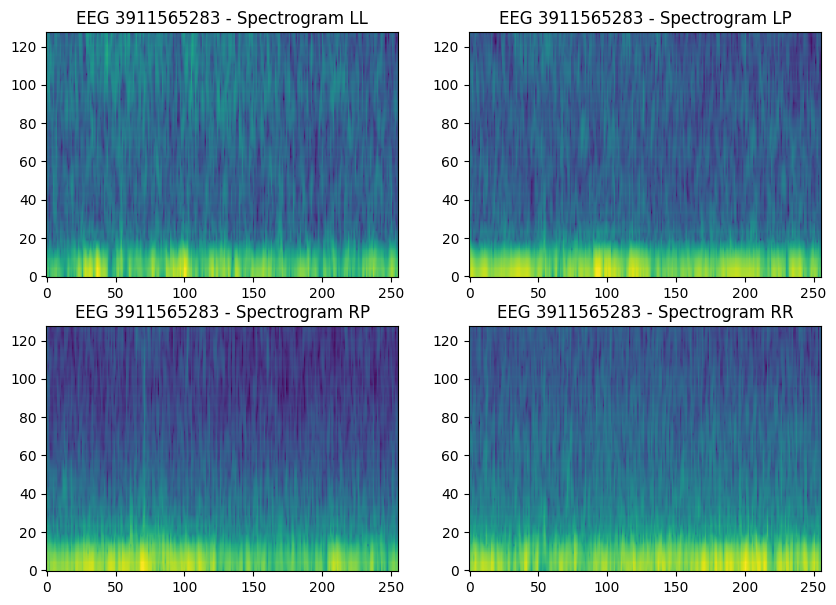

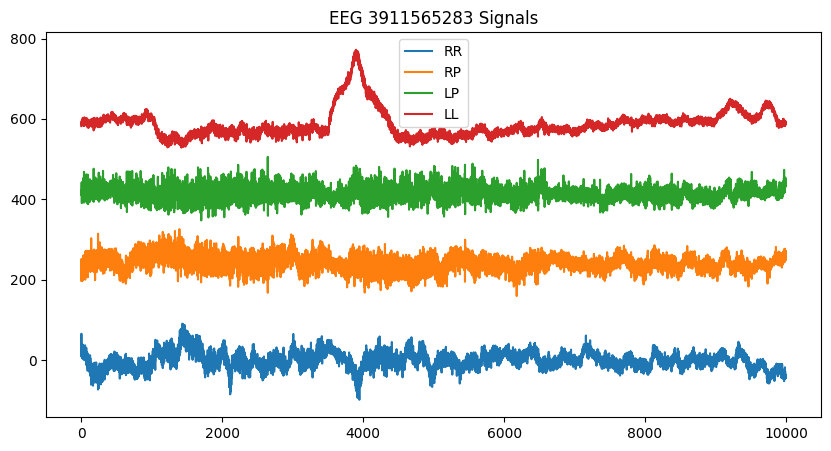


#########################



In [19]:
# READ ALL EEG SPECTROGRAMS
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'
DISPLAY = 1
EEG_IDS2 = test.eeg_id.unique()
all_eegs2 = {}

print('Converting Test EEG to Spectrograms...'); print()
for i, eeg_id in enumerate(EEG_IDS2):
        
    # CREATE SPECTROGRAM FROM EEG PARQUET
    img = spectrogram_from_eeg(f'{PATH2}{eeg_id}.parquet', i < DISPLAY)
    all_eegs2[eeg_id] = img

In [20]:
# INFER EFFICIENTNET ON TEST
preds = []
test_ds = EEGDataset(test, mode='test', specs=test_specs, eeg_specs=all_eegs2)
test_loader = DataLoader(test_ds, shuffle=False, batch_size=64, num_workers=3)

for i in range(5):
    print('#'*25)
    print(f'### Testing Fold {i+1}')

    ckpt_file = f'EffNet_v{VERSION}_f{i}.ckpt' if LOAD_MODELS_FROM is None else f'{LOAD_MODELS_FROM}/EffNet_v{VERSION}_f{i}.ckpt'
    model = EEGEffnetB0.load_from_checkpoint(ckpt_file)
    model.to(device).eval()
    fold_preds = []
    
    with torch.inference_mode():
        for test_batch in test_loader:
            test_batch = test_batch.to(device)
            pred = torch.softmax(model(test_batch), dim=1).cpu().numpy()
            fold_preds.append(pred)
        fold_preds = np.concatenate(fold_preds)

    preds.append(fold_preds)

pred = np.mean(preds,axis=0)
print()
print('Test preds shape',pred.shape)

#########################
### Testing Fold 1
#########################
### Testing Fold 2
#########################
### Testing Fold 3
#########################
### Testing Fold 4
#########################
### Testing Fold 5

Test preds shape (1, 6)


In [21]:
sub = pd.DataFrame({'eeg_id': test.eeg_id.values})
sub[TARGETS] = pred
sub.to_csv('submission.csv',index=False)
print('Submissionn shape',sub.shape)
sub.head()

Submissionn shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.24288,0.045547,0.000671,0.304879,0.044806,0.361217


In [22]:
# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
sub.iloc[:,-6:].sum(axis=1)

0    1.0
dtype: float32